In [2]:
import h5py
import healpy as hp
import numpy as np
import os 

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
from run_inference import (
    load_inference_results,
    print_inference_summary,
    load_likelihood_grid,
    solve_fagn_lambda,
)
import generate_gwsamples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Use serif font (will automatically pick an available serif font)
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress font warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

## Visualize Processed Pixelized Catalogs

### AGN and Gal catalogs

Loading catalogs from:
  Galaxy file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_galaxies.h5
  AGN file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_agn.h5

Galaxy catalog:
  Shape: (786432, 10)
  Total galaxies: 1176983
  Pixels with galaxies: 609945
  Max galaxies per pixel: 10
  Mean galaxies per pixel: 1.9

AGN catalog:
  Shape: (786432, 10)
  Total AGN: 1177354
  Pixels with AGN: 610458
  Max AGN per pixel: 10
  Mean AGN per pixel: 1.9


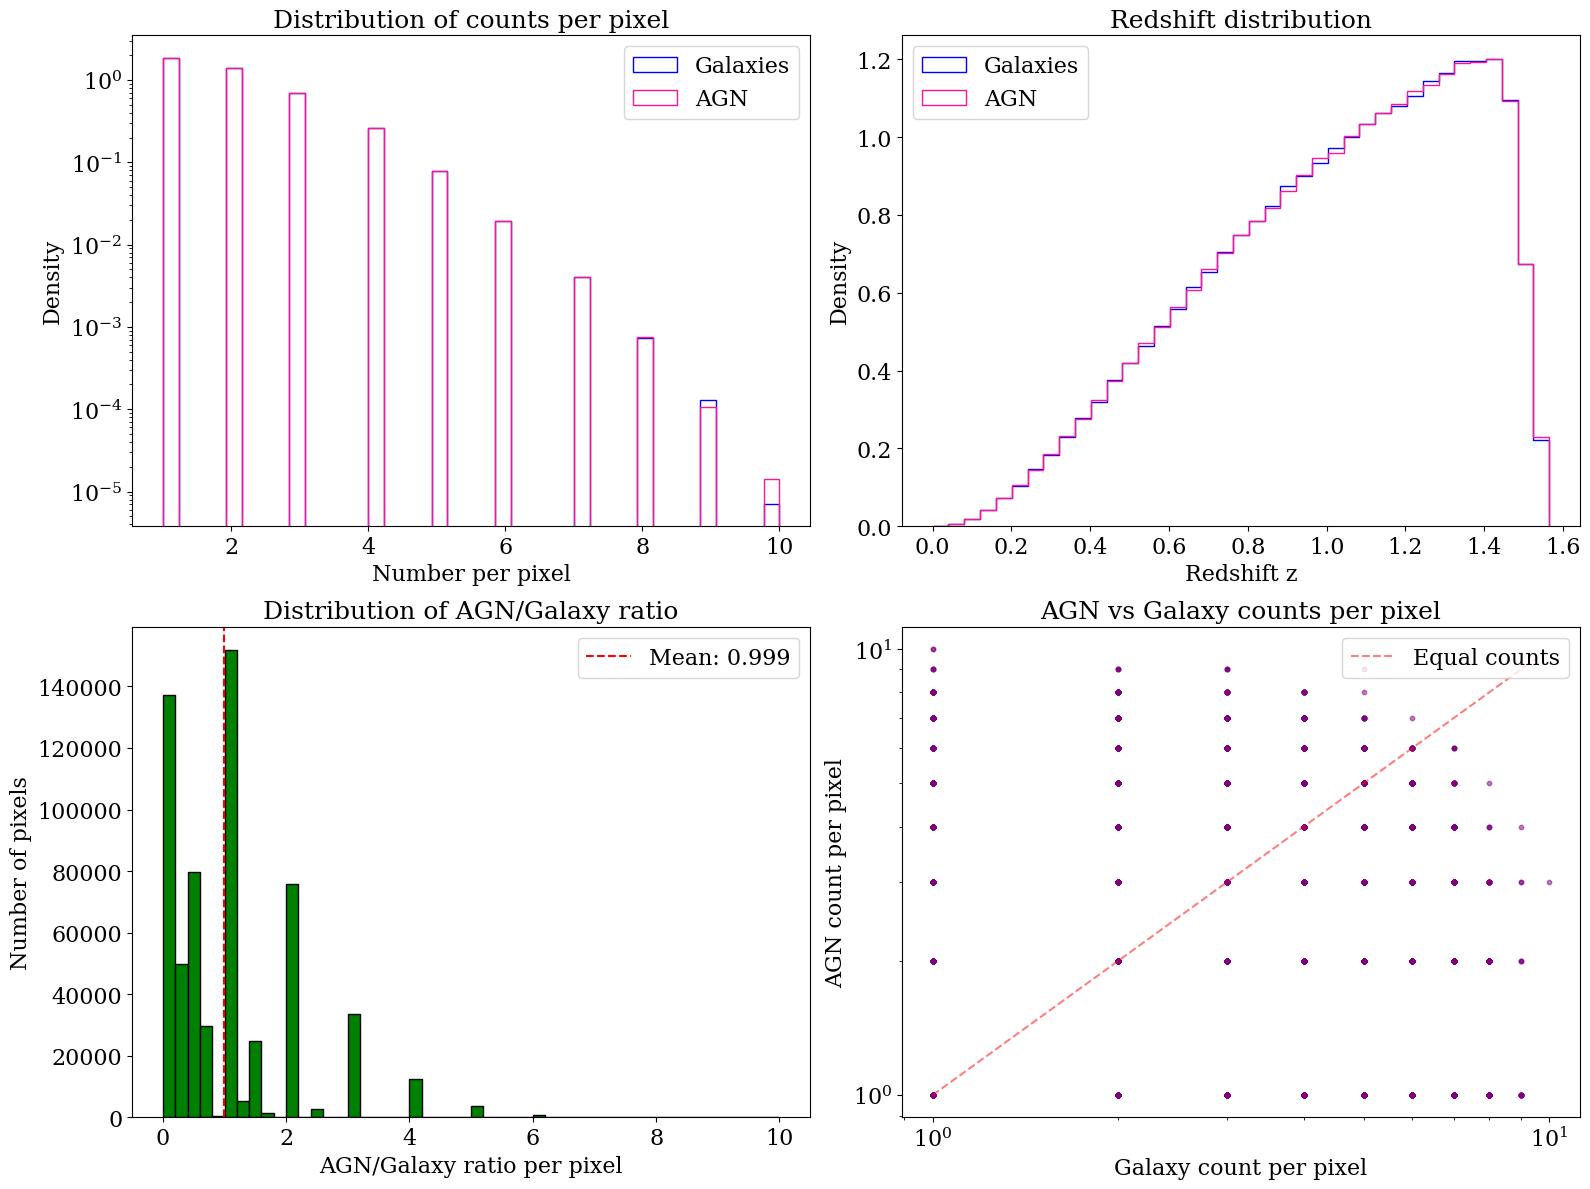

In [ ]:

# Set up paths
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
seed = 42
nside = 256

tag_mock_extra = f'_bgal{bias_gal}_bagn{bias_agn}'
tag_mock = f'_seed{seed}_ratioNgalNagn{ratioNgalNagn}{tag_mock_extra}'
dir_mock = f'../data/mocks_glass/mock{tag_mock}'
galaxy_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_galaxies.h5')
agn_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_agn.h5')

print(f"Loading catalogs from:")
print(f"  Galaxy file: {galaxy_file}")
print(f"  AGN file: {agn_file}")

# Load catalog data
with h5py.File(galaxy_file, 'r') as f:
    zgals = np.array(f['z'])
    ngals = np.array(f['n_in_pixel'])
    print(f"\nGalaxy catalog:")
    print(f"  Shape: {zgals.shape}")
    print(f"  Total galaxies: {ngals.sum()}")
    print(f"  Pixels with galaxies: {(ngals > 0).sum()}")
    print(f"  Max galaxies per pixel: {ngals.max()}")
    print(f"  Mean galaxies per pixel: {ngals[ngals > 0].mean():.1f}")

with h5py.File(agn_file, 'r') as f:
    zagns = np.array(f['z'])
    nagns = np.array(f['n_in_pixel'])
    print(f"\nAGN catalog:")
    print(f"  Shape: {zagns.shape}")
    print(f"  Total AGN: {nagns.sum()}")
    print(f"  Pixels with AGN: {(nagns > 0).sum()}")
    print(f"  Max AGN per pixel: {nagns.max()}")
    print(f"  Mean AGN per pixel: {nagns[nagns > 0].mean():.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Increase font sizes
fontsize = 16
title_fontsize = 18

# colors
color_gal = 'blue'
color_agn = 'deeppink'

# 1. Count distribution per pixel
ax = axes[0, 0]
all_counts = np.concatenate([ngals[ngals > 0], nagns[nagns > 0]])
bins = np.linspace(np.min(all_counts), np.max(all_counts), 40)
ax.hist(ngals[ngals > 0], bins=bins, alpha=1, label='Galaxies', color=color_gal, histtype='step', density=True)
ax.hist(nagns[nagns > 0], bins=bins, alpha=1, label='AGN', color=color_agn, histtype='step', density=True)
ax.set_xlabel('Number per pixel', fontsize=fontsize)
ax.set_ylabel('Density', fontsize=fontsize)
ax.set_title('Distribution of counts per pixel', fontsize=title_fontsize)
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_yscale('log')

# 2. Redshift distribution
ax = axes[0, 1]
# Extract valid redshifts (not NaN)
bins = np.linspace(0, np.max(np.concatenate([zgals[~np.isnan(zgals)], zagns[~np.isnan(zagns)]])), 40)
valid_zgals = zgals[~np.isnan(zgals)]
valid_zagns = zagns[~np.isnan(zagns)]
ax.hist(valid_zgals, bins=bins, alpha=1, label='Galaxies', color=color_gal, histtype='step', density=True)
ax.hist(valid_zagns, bins=bins, alpha=1, label='AGN', color=color_agn, histtype='step', density=True)
ax.set_xlabel('Redshift z', fontsize=fontsize)
ax.set_ylabel('Density', fontsize=fontsize)
ax.set_title('Redshift distribution', fontsize=title_fontsize)
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

# 3. Ratio of AGN to galaxies per pixel
ax = axes[1, 0]
mask = ngals > 0
ratio = np.zeros_like(ngals, dtype=float)
ratio[mask] = nagns[mask] / ngals[mask]
ratio[~mask] = np.nan
ax.hist(ratio[mask], bins=50, alpha=1, color='green', edgecolor='black')
ax.set_xlabel('AGN/Galaxy ratio per pixel', fontsize=fontsize)
ax.set_ylabel('Number of pixels', fontsize=fontsize)
ax.set_title('Distribution of AGN/Galaxy ratio', fontsize=title_fontsize)
ax.axvline(ratio[mask].mean(), color='red', linestyle='--', label=f'Mean: {ratio[mask].mean():.3f}')
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

# 4. Scatter plot: AGN vs Galaxy counts per pixel
ax = axes[1, 1]
ax.scatter(ngals, nagns, alpha=0.5, s=10, c='purple')
ax.set_xlabel('Galaxy count per pixel', fontsize=fontsize)
ax.set_ylabel('AGN count per pixel', fontsize=fontsize)
ax.set_title('AGN vs Galaxy counts per pixel', fontsize=title_fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
# Add diagonal line for equal counts
max_val = max(ngals.max(), nagns.max())
ax.plot([1, max_val], [1, max_val], 'r--', alpha=0.5, label='Equal counts')
ax.legend(fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# Print some statistics
# print(f"\nCatalog comparison:")
# print(f"  Pixels with both AGN and galaxies: {both_mask.sum()}")
# print(f"  Pixels with only galaxies: {((ngals > 0) & (nagns == 0)).sum()}")
# print(f"  Pixels with only AGN: {((ngals == 0) & (nagns > 0)).sum()}")
# print(f"  Empty pixels: {((ngals == 0) & (nagns == 0)).sum()}")
# print(f"\n  Mean AGN/Galaxy ratio (where galaxies > 0): {ratio_map[mask].mean():.3f}")
# print(f"  Median AGN/Galaxy ratio (where galaxies > 0): {np.nanmedian(ratio_map[mask]):.3f}")

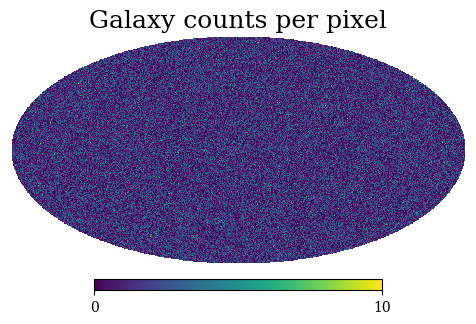

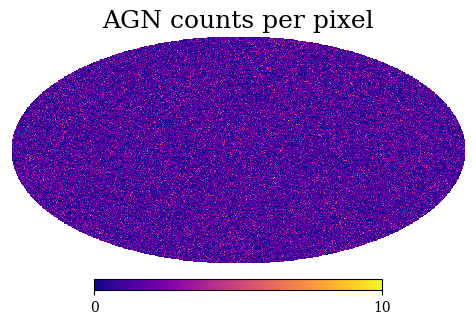

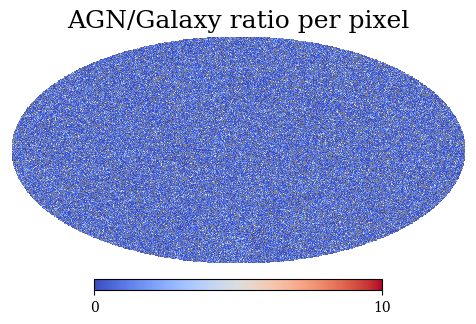

In [4]:
# Create sky maps - each in its own row
npix = hp.nside2npix(nside)
gal_map = np.zeros(npix)
gal_map[:len(ngals)] = ngals
agn_map = np.zeros(npix)
agn_map[:len(nagns)] = nagns

# Ratio map
ratio_map = np.zeros(npix, dtype=float)
mask = ngals > 0
ratio_map[:len(mask)][mask] = nagns[mask] / ngals[mask]
ratio_map[:len(mask)][~mask] = np.nan

figsize = (6,3)

# Sky map 1: Galaxy counts
fig = plt.figure(figsize=figsize)
hp.mollview(gal_map, title='Galaxy counts per pixel', cmap='viridis', 
            min=0, max=ngals.max(), fig=fig)
plt.title('Galaxy counts per pixel', fontsize=18)
plt.show()

# Sky map 2: AGN counts
fig = plt.figure(figsize=figsize)
hp.mollview(agn_map, title='AGN counts per pixel', cmap='plasma', 
            min=0, max=nagns.max(), fig=fig)
plt.title('AGN counts per pixel', fontsize=18)
plt.show()

# Sky map 3: AGN/Galaxy ratio
fig = plt.figure(figsize=figsize)
hp.mollview(ratio_map, title='AGN/Galaxy ratio per pixel', cmap='coolwarm', 
            fig=fig)
plt.title('AGN/Galaxy ratio per pixel', fontsize=18)
plt.show()

### GW injected sources & samples

In [28]:
# Settings for plotting GW sources and samples
config_data = '../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.25.yaml'
n_events = 100  # Set to None to use all events, or specify a number (e.g., 100)
n_samples_gw = 100  # Set to None to use all samples per event, or specify a number (e.g., 1000)

print(f"Plotting settings:")
print(f"  n_events: {n_events if n_events is not None else 'all'}")
print(f"  n_samples_gw: {n_samples_gw if n_samples_gw is not None else 'all'}")

Plotting settings:
  n_events: 100
  n_samples_gw: 100


In [29]:
# Load and plot GW sources
import yaml
import os

# Load config_data from YAML file
with open(config_data, 'r') as f:
    config_data_dict = yaml.safe_load(f)

# Construct GW file path from config_data
base_path = config_data_dict['paths']['base_path']
gw_samples_output = config_data_dict['paths']['gw_samples_output']
gw_file = os.path.join(base_path, gw_samples_output)

# Get nside from config (try pixelization first, then mock_catalog)
nside = config_data_dict.get('pixelization', {}).get('nside') or config_data_dict.get('mock_catalog', {}).get('nside', 256)
npix = hp.nside2npix(nside)


In [30]:

print(f"Loaded config from: {config_data}")
print(f"GW file: {gw_file}")
print(f"nside: {nside}")

# Load GW samples (returns separate arrays for galaxies and AGNs)
ra_gal, dec_gal, dL_gal, _, _, ra_agn, dec_agn, dL_agn, _, _ = generate_gwsamples.load_samples(gw_file, nsamp=n_samples_gw)

# Concatenate galaxies and AGNs (galaxies first, then AGNs - no shuffling)
ra_gw = np.concatenate([ra_gal, ra_agn], axis=0)
dec_gw = np.concatenate([dec_gal, dec_agn], axis=0)
dL_gw = np.concatenate([dL_gal, dL_agn], axis=0)

# Select nEvents if specified
if n_events is not None:
    ra_gw = ra_gw[:n_events]
    dec_gw = dec_gw[:n_events]
    dL_gw = dL_gw[:n_events]

print(f"Loaded {len(ra_gw)} GW source samples")
print(f"  RA range: [{np.degrees(ra_gw.min()):.1f}°, {np.degrees(ra_gw.max()):.1f}°]")
print(f"  Dec range: [{np.degrees(dec_gw.min()):.1f}°, {np.degrees(dec_gw.max()):.1f}°]")

# Load true injected GW positions from mock catalog
import h5py
mock_catalog_path = os.path.join(base_path, config_data_dict['paths']['mock_catalog'])
mock_gw_indices_path = os.path.join(base_path, config_data_dict['paths']['mock_gw_indices'])

print(f"\nLoading true injected positions from:")
print(f"  Mock catalog: {mock_catalog_path}")
print(f"  GW indices: {mock_gw_indices_path}")

# Load mock catalog
with h5py.File(mock_catalog_path, 'r') as f:
    ra_gal = np.asarray(f['ra_gal'])*np.pi/180  # Convert to radians
    dec_gal = np.asarray(f['dec_gal'])*np.pi/180
    ra_agn = np.asarray(f['ra_agn'])*np.pi/180
    dec_agn = np.asarray(f['dec_agn'])*np.pi/180

# Load GW indices
with h5py.File(mock_gw_indices_path, 'r') as f:
    i_gw_gal = np.asarray(f['i_gw_gal'])
    i_gw_agn = np.asarray(f['i_gw_agn'])

# Extract true injected positions
ra_gal_gw_true = ra_gal[i_gw_gal]
dec_gal_gw_true = dec_gal[i_gw_gal]
ra_agn_gw_true = ra_agn[i_gw_agn]
dec_agn_gw_true = dec_agn[i_gw_agn]

# Combine all true injected positions (galaxies first, then AGNs, matching original order before shuffling)
ra_gw_true_all = np.concatenate([ra_gal_gw_true, ra_agn_gw_true])
dec_gw_true_all = np.concatenate([dec_gal_gw_true, dec_agn_gw_true])

print(f"Loaded {len(ra_gw_true_all)} true injected GW positions")

Loaded config from: ../configs/configs_data/config_data_seed42_ratioNgalNagn1_bgal1.0_bagn1.0_fagn0.25_lambdaagn0.25.yaml
GW file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.25_lambdaagn0.25_N1000_seed1042.h5
nside: 256
Loading GW samples from ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.25_lambdaagn0.25_N1000_seed1042.h5 (nEvents=100, nsamp=100)
Loaded 100 GW source samples
  RA range: [0.1°, 360.0°]
  Dec range: [-78.4°, 77.0°]

Loading true injected positions from:
  Mock catalog: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/mock_catalog.h5
  GW indices: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gws_fagn0.25_lambdaagn0.25_N1000_seed1042.h5
Loaded 1000 true injected GW positions


Matched 100 sample events to true injected positions


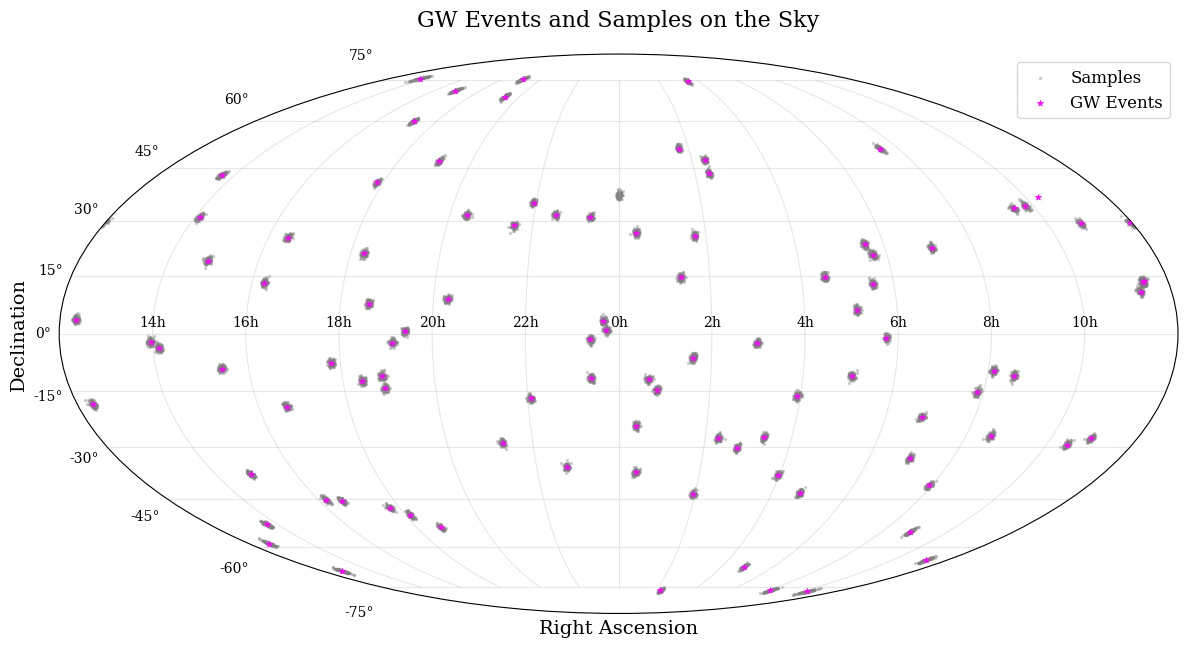

In [31]:
# Get all samples (ra_gw and dec_gw are 2D arrays with shape (nEvents, nsamp))
# Samples are in same order as true injected positions: galaxies first, then AGNs
if ra_gw.ndim == 2:
    ra_all_samples = ra_gw.flatten()
    dec_all_samples = dec_gw.flatten()
    nEvents_loaded = ra_gw.shape[0]
else:
    # If already flattened, reshape using known dimensions
    nEvents_loaded = ra_gw.shape[0] // n_samples_gw if n_samples_gw else len(ra_gw)
    nsamp_loaded = n_samples_gw if n_samples_gw else 1
    ra_gw_2d = ra_gw.reshape(nEvents_loaded, nsamp_loaded)
    dec_gw_2d = dec_gw.reshape(nEvents_loaded, nsamp_loaded)
    ra_all_samples = ra_gw
    dec_all_samples = dec_gw

# Use true injected positions in same order (galaxies first, then AGNs)
# No shuffling is done in generate_gwsamples, so order matches exactly
ra_events = ra_gw_true_all[:nEvents_loaded]
dec_events = dec_gw_true_all[:nEvents_loaded]

# Convert RA from [0, 2π] to [-π, π] for Mollweide projection
# RA and dec are already in radians
ra_events_plot = np.where(ra_events > np.pi, ra_events - 2*np.pi, ra_events)
ra_all_samples_plot = np.where(ra_all_samples > np.pi, ra_all_samples - 2*np.pi, ra_all_samples)

# Plot scatter plot of GW events and samples on the sky with Mollweide projection
figsize = (12, 8)
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': 'mollweide'})

# Plot all samples as small points
ax.scatter(ra_all_samples_plot, dec_all_samples, c='gray', s=2, alpha=0.3, label='Samples', rasterized=True)

# Plot GW events as big stars
ax.scatter(ra_events_plot, dec_events, c='magenta', s=20, marker='*', 
           edgecolors=None, linewidths=0.5, label='GW Events', zorder=10)

ax.set_xlabel('Right Ascension', fontsize=14)
ax.set_ylabel('Declination', fontsize=14)
ax.set_title('GW Events and Samples on the Sky', fontsize=16, pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Set tick labels to show degrees
ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
plt.tight_layout()
plt.show()

## Compute and Plot Likelihood Grid


In [16]:
# Set up paths and parameters for loading likelihood grid
import sys
import os
sys.path.append('../code')

# Define file paths (same parameters as main inference)
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
#lambda_agn = 0.5
lambda_agn = 0.0
N_gw = 1000
seed = 42
gw_seed = 1042
nside = 256

tag_mock_extra = f'_bgal{bias_gal}_bagn{bias_agn}'
tag_mock = f'_seed{seed}_ratioNgalNagn{ratioNgalNagn}{tag_mock_extra}'
tag_inf = f'_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}_nside{nside}_norm'

# Path to saved likelihood grid (from run_inference.py with mode='likelihood_grid')
likelihood_grid_file = f'../results/inference/likelihood_grid{tag_inf}.h5'

print(f"Loading likelihood grid from: {likelihood_grid_file}")


Loading likelihood grid from: ../results/inference/likelihood_grid_fagn0.5_lambdaagn0.0_N1000_seed1042_nside256_norm.h5


In [17]:
# Load likelihood grid from saved file
print("Loading likelihood grid...")
likelihood_results = load_likelihood_grid(likelihood_grid_file)

# Extract data from loaded results
log_likelihood_grid = likelihood_results['log_likelihood_grid']
H0_grid = likelihood_results['H0_grid']
f_grid = likelihood_results['f_grid']
config = likelihood_results.get('config', {})
metadata = likelihood_results.get('metadata', {})
grid_params = likelihood_results.get('grid_params', {})

# Get parameters from config/metadata if available
N_gw = config.get('nEvents', metadata.get('nEvents', N_gw))
nside = config.get('nside', metadata.get('nside', nside))

# Load truth values from config (saved parameters from run_inference.py)
truth_f_agn = config.get('f_agn', None)
truth_lambda_agn = config.get('lambda_agn', None)
truth_H0 = metadata.get('H0Planck', None)
if truth_f_agn is None:
    truth_f_agn = f_agn
if truth_lambda_agn is None:
    truth_lambda_agn = lambda_agn

# Calculate truth_f (frac_agn) from f_agn and lambda_agn
import sys
sys.path.append('../code')
import utils
N_gal_truth = metadata.get('N_gal')
N_agn_truth = metadata.get('N_agn')
if N_gal_truth is not None and N_agn_truth is not None and truth_f_agn is not None and truth_lambda_agn is not None:
    _, truth_f = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)
else:
    truth_f = None

print(f"Loaded likelihood grid with shape: {log_likelihood_grid.shape}")
print(f"H0 grid: {len(H0_grid)} points from {H0_grid.min():.1f} to {H0_grid.max():.1f}")
print(f"f grid: {len(f_grid)} points from {f_grid.min():.3f} to {f_grid.max():.3f}")
if grid_params:
    print(f"Grid parameters: Om0={grid_params.get('Om0', 'N/A')}, "
          f"gamma_agn={grid_params.get('gamma_agn', 'N/A')}, "
          f"gamma_gal={grid_params.get('gamma_gal', 'N/A')}")

# Note: The saved grid has shape (n_H0, n_f), but plotting code expects (n_f, n_H0)
# Transpose to match the expected convention for plotting
if log_likelihood_grid.shape[0] == len(H0_grid) and log_likelihood_grid.shape[1] == len(f_grid):
    log_likelihood_grid = log_likelihood_grid.T  # Transpose to (n_f, n_H0)
    print(f"Transposed grid to shape: {log_likelihood_grid.shape} for plotting")

# Create meshgrid for plotting
H0_mesh, f_mesh = np.meshgrid(H0_grid, f_grid)


Loading likelihood grid...
Loading likelihood grid from ../results/inference/likelihood_grid_fagn0.5_lambdaagn0.0_N1000_seed1042_nside256_norm.h5
Loaded likelihood grid with shape: (20, 20)
H0 grid: 20 points from 50.0 to 100.0
f grid: 20 points from 0.000 to 1.000
Grid parameters: Om0=None, gamma_agn=0, gamma_gal=0
Transposed grid to shape: (20, 20) for plotting


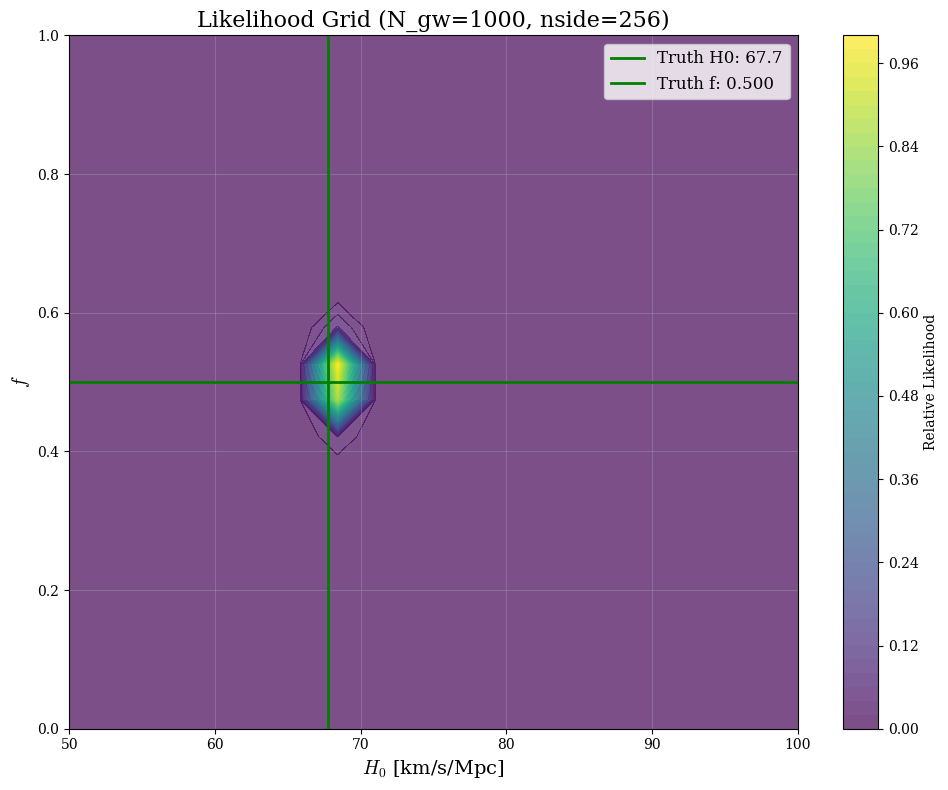

In [18]:
# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(10, 8))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# # Create contour plot
# contour_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
# CS = ax.contour(H0_mesh, f_mesh, likelihood_grid, levels=contour_levels, 
#                 colors='black', alpha=0.6, linewidths=1.5)
# ax.clabel(CS, inline=True, fontsize=10, fmt='%.1f')

# Fill contours
im = ax.contourf(H0_mesh, f_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Add truth values as green lines (from config)
if truth_H0 is not None:
    ax.axvline(truth_H0, color='green', linestyle='-', linewidth=2, label=f'Truth H0: {truth_H0:.1f}')
if truth_f is not None:
    ax.axhline(truth_f, color='green', linestyle='-', linewidth=2, label=f'Truth f: {truth_f:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$f$', fontsize=14)
ax.set_title(f'Likelihood Grid (N_gw={N_gw}, nside={nside})', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


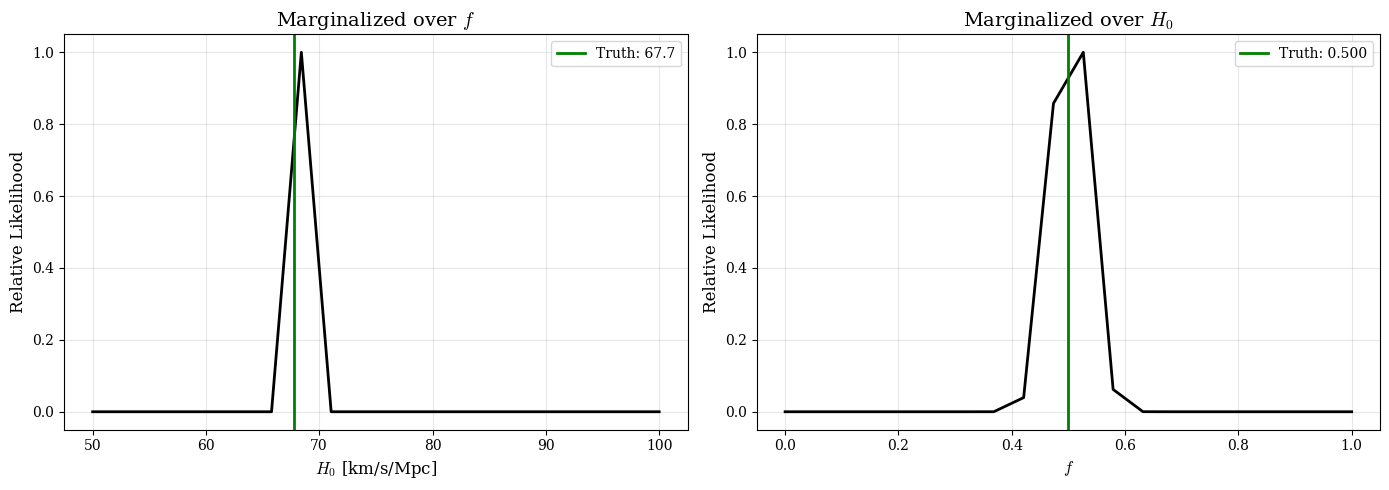

In [19]:
# Plot 1D marginal likelihoods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Marginalize over f to get H0 likelihood
H0_likelihood = np.nansum(likelihood_grid, axis=0)
H0_likelihood = H0_likelihood / np.nanmax(H0_likelihood)

axes[0].plot(H0_grid, H0_likelihood, 'k-', linewidth=2)
#axes[0].axvline(H0_max_val, color='r', linestyle='--', label=f'Max at {H0_max_val:.1f}')
# Add truth value (from config)
if truth_H0 is not None:
    axes[0].axvline(truth_H0, color='green', linestyle='-', linewidth=2, label=f'Truth: {truth_H0:.1f}')
axes[0].set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=12)
axes[0].set_ylabel('Relative Likelihood', fontsize=12)
axes[0].set_title('Marginalized over $f$', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Marginalize over H0 to get f likelihood
f_likelihood = np.nansum(likelihood_grid, axis=1)
f_likelihood = f_likelihood / np.nanmax(f_likelihood)

axes[1].plot(f_grid, f_likelihood, 'k-', linewidth=2)
#axes[1].axvline(f_max_val, color='r', linestyle='--', label=f'Max at {f_max_val:.3f}')
# Add truth value (from config)
if truth_f is not None:
    axes[1].axvline(truth_f, color='green', linestyle='-', linewidth=2, label=f'Truth: {truth_f:.3f}')
axes[1].set_xlabel(r'$f$', fontsize=12)
axes[1].set_ylabel('Relative Likelihood', fontsize=12)
axes[1].set_title('Marginalized over $H_0$', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


N_gal = 1176983.0, N_agn = 1177354.0

Marginalized distributions:
f_agn: mean = 0.2834, std = 0.1482, median = 0.2784
lambda_agn: mean = 0.2834, std = 0.1482, median = 0.2783


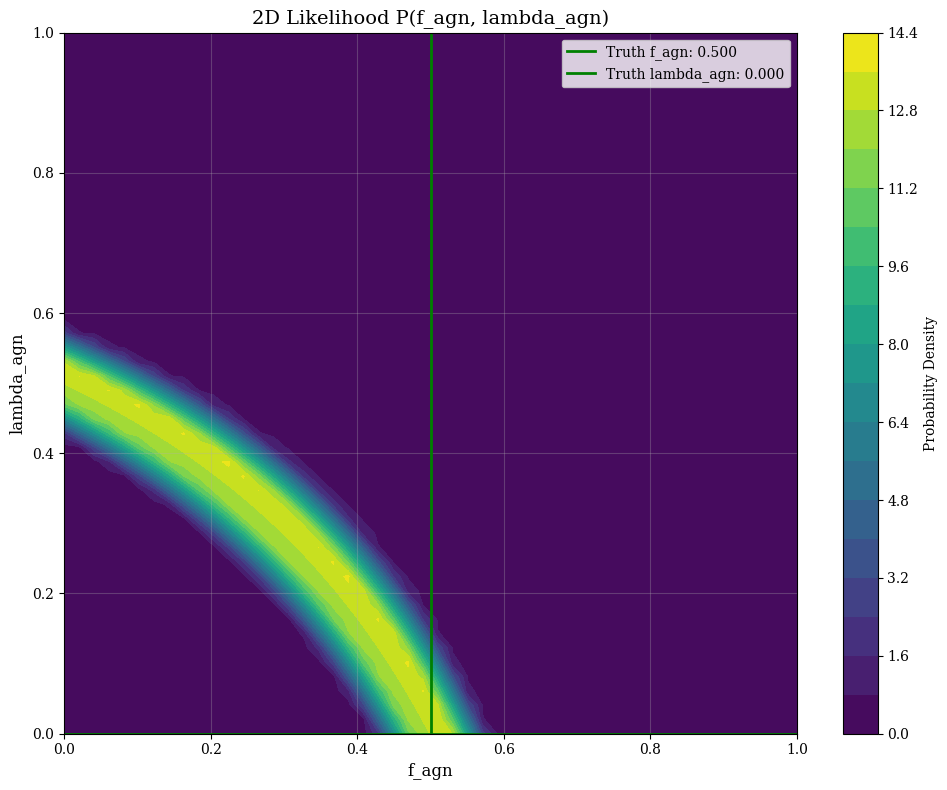

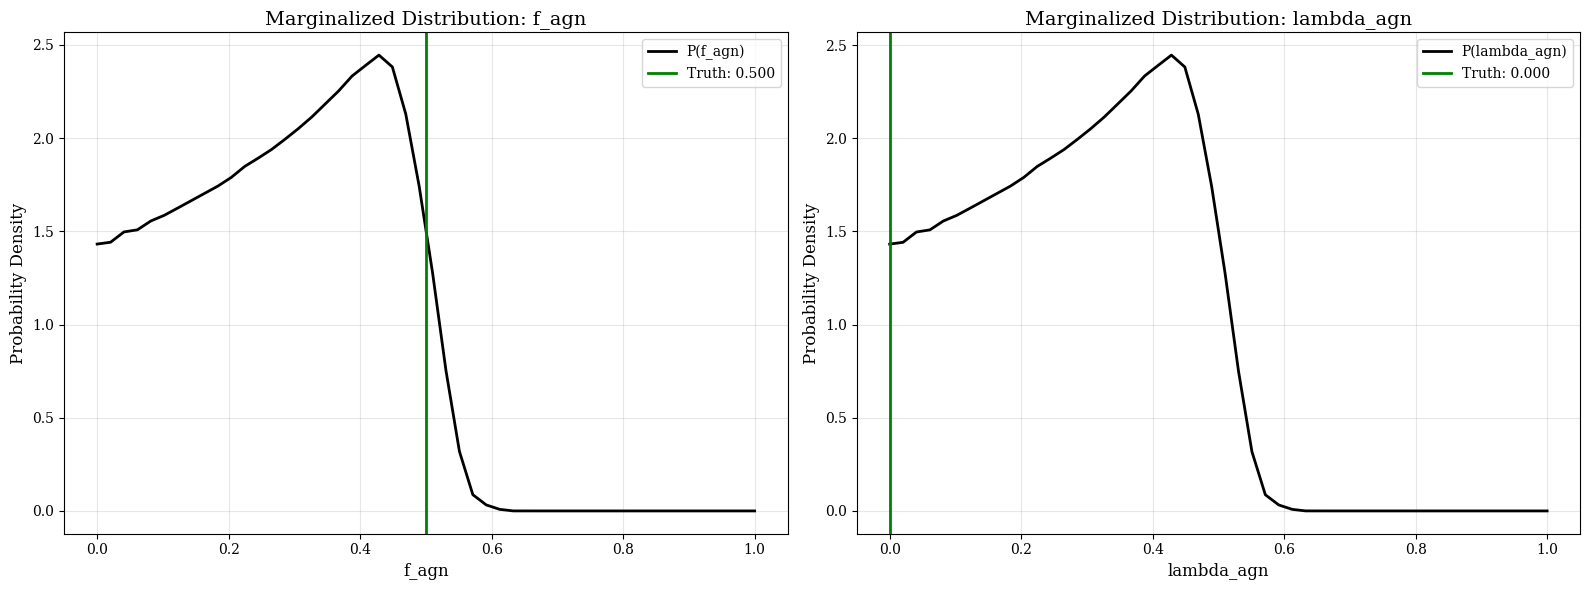

In [20]:
# Solve for f_agn and lambda_agn from likelihood grid
# The likelihood grid is on (H0, f) where f is the observed AGN fraction (frac_agn)
# We need to convert this to distributions for (f_agn, lambda_agn)

import sys
sys.path.append('../code')
import utils
from scipy.interpolate import interp1d
from scipy.special import logsumexp

# Get N_gal and N_agn from metadata
N_gal = metadata.get('N_gal')
N_agn = metadata.get('N_agn')
if N_gal is None or N_agn is None:
    raise ValueError("N_gal or N_agn missing from metadata; cannot solve for f_agn and lambda_agn.")

print(f"N_gal = {N_gal}, N_agn = {N_agn}")

# Step 1: Marginalize over H0 to get 1D likelihood on f
# The grid shape is (n_H0, n_f) - we need to marginalize over H0 (axis 0)
# Use logsumexp for numerical stability

# Work with a copy to avoid modifying the original (in case it was transposed for plotting)
log_likelihood_grid_work = log_likelihood_grid.copy()
H0_grid_work = H0_grid.copy()
f_grid_work = f_grid.copy()

# Ensure grid is in correct shape: (n_H0, n_f)
# Check if grid was transposed for plotting (shape would be n_f, n_H0)
if log_likelihood_grid_work.shape[0] == len(f_grid_work) and log_likelihood_grid_work.shape[1] == len(H0_grid_work):
    # Grid was transposed for plotting, transpose back
    log_likelihood_grid_work = log_likelihood_grid_work.T

# Marginalize over H0: log P(f) = log sum_H0 exp(log P(H0, f))
log_likelihood_f = logsumexp(log_likelihood_grid_work, axis=0)  # Shape: (n_f,)

# Convert to probability (normalize)
likelihood_f = np.exp(log_likelihood_f - log_likelihood_f.max())  # Subtract max for numerical stability
likelihood_f = likelihood_f / np.trapz(likelihood_f, f_grid_work)  # Normalize

# Step 2: Create interpolation function for likelihood on f
likelihood_interp = interp1d(f_grid_work, likelihood_f, kind='linear', 
                            bounds_error=False, fill_value=0.0)

# Step 3: Create grid of (f_agn, lambda_agn) values
n_fagn = 50
n_lambda = 50
f_agn_grid = np.linspace(0, 1, n_fagn)
lambda_agn_grid = np.linspace(0, 1, n_lambda)

# Step 4: For each (f_agn, lambda_agn) pair, compute corresponding f value
# and get likelihood from interpolation
likelihood_fagn_lambda = np.zeros((n_fagn, n_lambda))

for i, f_agn_val in enumerate(f_agn_grid):
    for j, lambda_agn_val in enumerate(lambda_agn_grid):
        # Compute the observed AGN fraction f for this (f_agn, lambda_agn) pair
        _, frac_agn = utils.compute_gw_host_fractions(N_gal, N_agn, f_agn_val, lambda_agn=lambda_agn_val)
        
        # Get likelihood from interpolation
        likelihood_fagn_lambda[i, j] = likelihood_interp(frac_agn)

# Normalize the 2D likelihood
likelihood_fagn_lambda = likelihood_fagn_lambda / np.trapz(np.trapz(likelihood_fagn_lambda, 
                                                                     lambda_agn_grid, axis=1), 
                                                           f_agn_grid)

# Step 5: Marginalize to get 1D distributions
# P(f_agn) = integral P(f_agn, lambda_agn) d(lambda_agn)
likelihood_fagn = np.trapz(likelihood_fagn_lambda, lambda_agn_grid, axis=1)
likelihood_fagn = likelihood_fagn / np.trapz(likelihood_fagn, f_agn_grid)  # Normalize

# P(lambda_agn) = integral P(f_agn, lambda_agn) d(f_agn)
likelihood_lambda = np.trapz(likelihood_fagn_lambda, f_agn_grid, axis=0)
likelihood_lambda = likelihood_lambda / np.trapz(likelihood_lambda, lambda_agn_grid)  # Normalize

# Compute summary statistics
# For f_agn
fagn_mean = np.trapz(f_agn_grid * likelihood_fagn, f_agn_grid)
fagn_std = np.sqrt(np.trapz((f_agn_grid - fagn_mean)**2 * likelihood_fagn, f_agn_grid))
# Find median
fagn_cdf = np.cumsum(likelihood_fagn) * (f_agn_grid[1] - f_agn_grid[0])
fagn_median = np.interp(0.5, fagn_cdf, f_agn_grid)

# For lambda_agn
lambda_mean = np.trapz(lambda_agn_grid * likelihood_lambda, lambda_agn_grid)
lambda_std = np.sqrt(np.trapz((lambda_agn_grid - lambda_mean)**2 * likelihood_lambda, lambda_agn_grid))
# Find median
lambda_cdf = np.cumsum(likelihood_lambda) * (lambda_agn_grid[1] - lambda_agn_grid[0])
lambda_median = np.interp(0.5, lambda_cdf, lambda_agn_grid)

print(f"\nMarginalized distributions:")
print(f"f_agn: mean = {fagn_mean:.4f}, std = {fagn_std:.4f}, median = {fagn_median:.4f}")
print(f"lambda_agn: mean = {lambda_mean:.4f}, std = {lambda_std:.4f}, median = {lambda_median:.4f}")

# Plot results - split into 2 separate figures for better visibility

# Get truth values from config (already loaded in cell 8)
truth_f_agn_plot = truth_f_agn
truth_lambda_agn_plot = truth_lambda_agn

# Figure 1: 2D likelihood
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
im = ax1.contourf(f_agn_grid, lambda_agn_grid, likelihood_fagn_lambda.T, levels=20, cmap='viridis')
# Add truth values as green lines
if truth_f_agn_plot is not None:
    ax1.axvline(truth_f_agn_plot, color='green', linestyle='-', linewidth=2, label=f'Truth f_agn: {truth_f_agn_plot:.3f}')
if truth_lambda_agn_plot is not None:
    ax1.axhline(truth_lambda_agn_plot, color='green', linestyle='-', linewidth=2, label=f'Truth lambda_agn: {truth_lambda_agn_plot:.3f}')
ax1.set_xlabel('f_agn', fontsize=12)
ax1.set_ylabel('lambda_agn', fontsize=12)
ax1.set_title('2D Likelihood P(f_agn, lambda_agn)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
plt.colorbar(im, ax=ax1, label='Probability Density')
plt.tight_layout()
plt.show()

# Figure 2: 1D marginalized distributions
fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot marginalized f_agn distribution
axes[0].plot(f_agn_grid, likelihood_fagn, 'k-', linewidth=2, label='P(f_agn)')
# Add truth value
if truth_f_agn_plot is not None:
    axes[0].axvline(truth_f_agn_plot, color='green', linestyle='-', linewidth=2, label=f'Truth: {truth_f_agn_plot:.3f}')
axes[0].set_xlabel('f_agn', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Marginalized Distribution: f_agn', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot marginalized lambda_agn distribution
axes[1].plot(lambda_agn_grid, likelihood_lambda, 'k-', linewidth=2, label='P(lambda_agn)')
# Add truth value
if truth_lambda_agn_plot is not None:
    axes[1].axvline(truth_lambda_agn_plot, color='green', linestyle='-', linewidth=2, label=f'Truth: {truth_lambda_agn_plot:.3f}')
axes[1].set_xlabel('lambda_agn', fontsize=12)
axes[1].set_ylabel('Probability Density', fontsize=12)
axes[1].set_title('Marginalized Distribution: lambda_agn', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Setup and Load inference results

In [23]:
# Define inference results path
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
lambda_agn = 0.0
N_gw = 1000
seed = 42
gw_seed = 1042

tag_inf = f'_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}_nside{nside}_norm'
output_file = f'../results/inference/inference_results{tag_inf}.h5'


In [24]:
loaded_results = load_inference_results(output_file)
print_inference_summary(loaded_results)

# Load truth values from config (saved parameters from run_inference.py)
config = loaded_results.get('config', {})
metadata = loaded_results.get('metadata', {})

# Get parameters from config if available, otherwise fall back to metadata or defaults
truth_f_agn = config.get('f_agn', None)
truth_lambda_agn = config.get('lambda_agn', None)
truth_H0 = metadata.get('H0Planck', 67.74)  # Use H0Planck as truth value
if truth_f_agn is None:
    truth_f_agn = f_agn
if truth_lambda_agn is None:
    truth_lambda_agn = lambda_agn

# Calculate truth_f (frac_agn) from f_agn and lambda_agn
import sys
sys.path.append('../code')
import utils
N_gal_truth = metadata.get('N_gal')
N_agn_truth = metadata.get('N_agn')
if N_gal_truth is None or N_agn_truth is None:
    raise ValueError("N_gal or N_agn missing from metadata; cannot calculate truth_f.")
_, truth_f = utils.compute_gw_host_fractions(N_gal_truth, N_agn_truth, truth_f_agn, lambda_agn=truth_lambda_agn)

print(f"\nTruth values (from config):")
print(f"  H0 (truth): {truth_H0:.2f} km/s/Mpc")
print(f"  f_agn (truth): {truth_f_agn:.3f}")
print(f"  lambda_agn (truth): {truth_lambda_agn:.3f}")
print(f"  f (frac_agn, truth): {truth_f:.3f}")


Loading inference results from ../results/inference/inference_results_fagn0.5_lambdaagn0.0_N1000_seed1042_nside256_norm.h5
Printing inference results summary
Inference Results Summary
Timestamp: 2025-12-11T00:07:11.285131
Number of samples: 12800
Number of parameters: 2

MCMC Parameters:
  $H_0$: [50, 100]
  $f$: [0, 1]

Configuration:
  galaxy_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_galaxies.h5
  agn_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_agn.h5
  gw_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.0_N1000_seed1042.h5
  nside: 256
  nEvents: 1000
  nsamp: 10000
  n_walkers: 16
  n_steps: 1000

Metadata:
  H0Planck: 67.74
  Om0Planck: 0.3075
  N_gal: 1176983.0
  N_agn: 1177354.0

Posterior Samples Shape: (12800, 2)
Parameter means:
  $H_0$: 67.7888 ± 0.0569
  $f$: 0.5210 ± 0.0307

Truth values (from config):
  H0 (truth)

In [ ]:
# Access data
samples = loaded_results['posterior_samples']
config = loaded_results['config']
metadata = loaded_results['metadata']
mcmc_params = loaded_results.get('mcmc_params', {})
labels = mcmc_params.get('labels', [f'param_{i}' for i in range(samples.shape[1])])

In [25]:
# Access data
samples = loaded_results['posterior_samples']
config = loaded_results['config']
metadata = loaded_results['metadata']
mcmc_params = loaded_results.get('mcmc_params', {})
labels = mcmc_params.get('labels', [f'param_{i}' for i in range(samples.shape[1])])

### Plot histograms

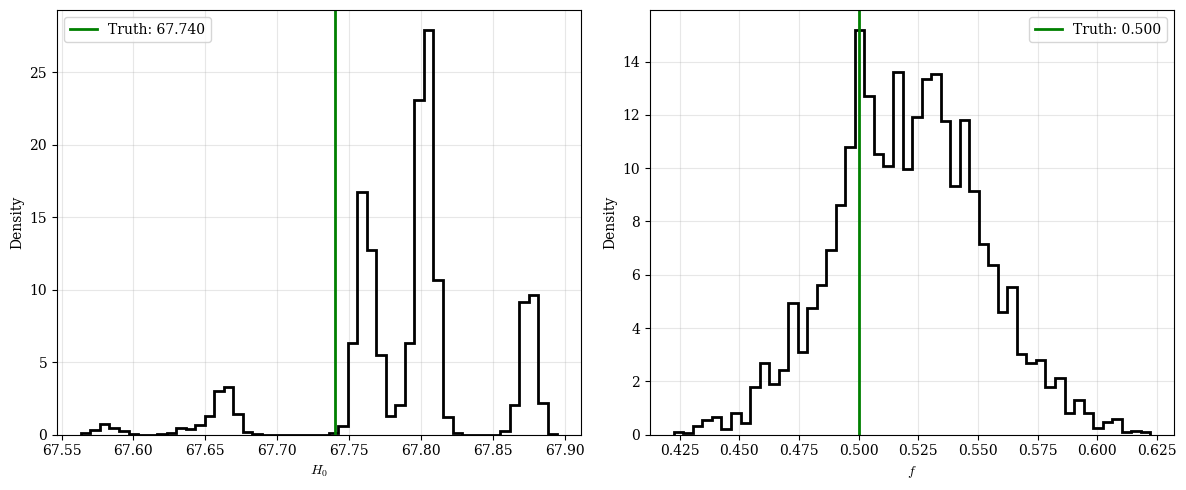

In [26]:
# Plot histograms for each parameter
n_params = samples.shape[1]
fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))

if n_params == 1:
    axes = [axes]

# Truth values array
truth_values = [truth_H0, truth_f]

for i, (ax, label) in enumerate(zip(axes, labels)):
    ax.hist(samples[:, i], bins=50, density=True, lw=2, color='black', histtype='step')
    # Overplot truth value
    ax.axvline(truth_values[i], color='green', linestyle='-', linewidth=2,
               label=f'Truth: {truth_values[i]:.3f}')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Corner plot


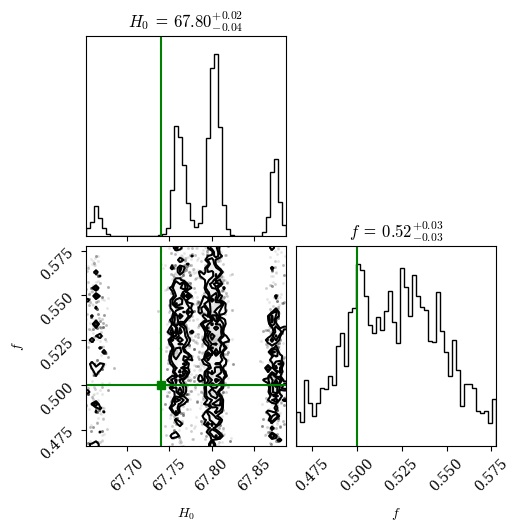

In [27]:
# Corner plot
import corner
import numpy as np

# Calculate ranges for each parameter that include truth values and majority of samples
truths = [truth_H0, truth_f]
ranges = []
buffer_factor = 0.05  # 5% buffer on each side

for i in range(samples.shape[1]):
    # Get the 5th and 95th percentiles to include majority of samples
    sample_min = np.percentile(samples[:, i], 5)
    sample_max = np.percentile(samples[:, i], 95)
    
    # Include truth value in range
    truth_val = truths[i]
    param_min = min(sample_min, truth_val)
    param_max = max(sample_max, truth_val)
    
    # Add buffer
    range_size = param_max - param_min
    param_min = param_min - buffer_factor * range_size
    param_max = param_max + buffer_factor * range_size
    
    ranges.append((param_min, param_max))

fig = corner.corner(samples, labels=labels, show_titles=True, 
                    title_kwargs={"fontsize": 12}, bins=50,
                    truths=[truth_H0, truth_f], truth_color='green', 
                    truth_kwargs={'linestyle': '-', 'linewidth': 2},
                    range=ranges)
plt.show()


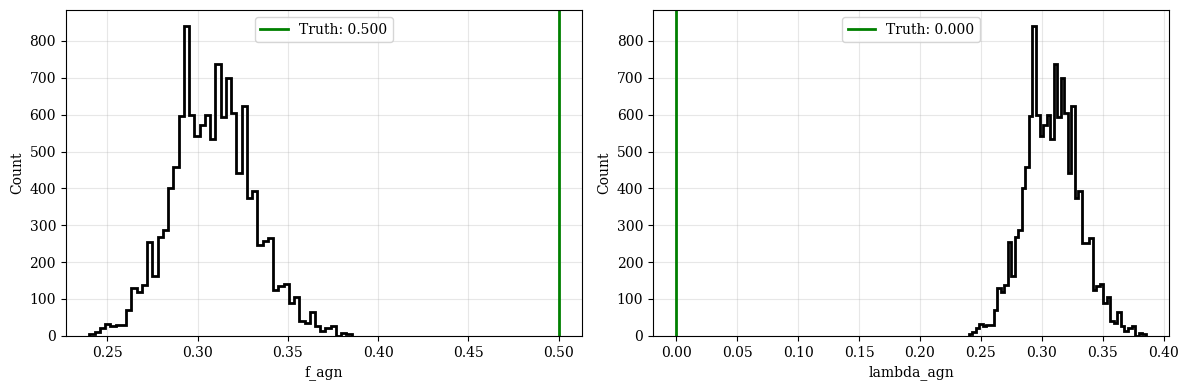

In [ ]:
### TODO this isn't the right way to do this

# Solve for f_agn and lambda_agn from posterior f samples and plot
frac_agn_samples = samples[:, 1]  # f corresponds to frac_agn in this inference

N_gal = metadata.get('N_gal')
N_agn = metadata.get('N_agn')
if N_gal is None or N_agn is None:
    raise ValueError("N_gal or N_agn missing from metadata; cannot solve for f_agn and lambda_agn.")

fagn_solutions = []
lambda_solutions = []
for ff in frac_agn_samples:
    f_sol, lam_sol = solve_fagn_lambda(ff, N_gal, N_agn)
    fagn_solutions.append(f_sol)
    lambda_solutions.append(lam_sol)

fagn_solutions = np.array(fagn_solutions)
lambda_solutions = np.array(lambda_solutions)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(fagn_solutions, bins=50, color='k', histtype='step', lw=2)
axes[0].axvline(truth_f_agn, color='green', linestyle='-', linewidth=2, label=f"Truth: {truth_f_agn:.3f}")
axes[0].set_xlabel('f_agn')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(lambda_solutions, bins=50, color='k', histtype='step', lw=2)
axes[1].axvline(lambda_agn, color='green', linestyle='-', linewidth=2, label=f"Truth: {lambda_agn:.3f}")
axes[1].set_xlabel('lambda_agn')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
